# Language Processing 2 exam, Spring 2016

Mace Ojala <spt864@alumni.ku.dk>

## Introduction

Probabilistic context-free grammar (PCFG) experiments are carried on a standard, structurally annotated linguistic corpus, the Penn Treebank. The parser in question is `BitPar`. After engineering the data, tools, and the experiments into an object oriented model, two experiments are run and results presented, with error analysis and discussion of the task.

Parsing is a subtask in many natural language processing (NLP) scenarios. Typically it itself is build on top of other tasks such as tokenization and part-of-speech (POS) tagging, and provides input for semantic analysis, machine translation (ML), query parsing and document reprentation in information retrieval (IR), speech recognition and so on. The aim of the parsing task is to figure out a syntactic, or semantic for input sentences, which are typically a list of words, such as sentences from text.

Parsing has a long history in the context of linguistics, as well as in computational linguistics, and cognitive sciences too; how do humans comprehend language? Parsing is also important with non-natural languages, such as software compilers and analysis, formal logic and so on.

The ubiquitous *statistical turn* has affected parsing, like it has affected most other fields of research too. Some say, that nowadays axiomatic, or rule-based strategies are having a reneissance, to re-introduce human knowledge into models built using machine learning (ML) and other data-driven methods, inference and statistics.

This paper looks at grammar-based parsers, and more specifically one particular implementation of a probabilistic extension of CFGs.

![A Danish forest](https://c1.staticflickr.com/1/176/372081931_16469cd9ae_z.jpg?zz=1 "Gilleleje forest, in Denmark, image courtecy of Flickr user Pichu, https://www.flickr.com/photos/oa_pichu_sis/372081931")

In [1]:
import zipfile
import os
import re
import nltk
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Software and data setup

The two programs, the PCFG parser *BitPar* and parser-evaluation utility *EVALB* were downloaded from http://cst.dk/jurgen/lp2_ex2016, and built with Make. The former caused no issues, but the latter yielded a dozen or so warnings from the compiler. It is assumed that these warnings will not impact the results of this report.

The data was downloaded from http://cst.dk/jurgen/lp2_ex2016. It is stored in one zip file titled `ptb_trees.zip`.

In [2]:
treedatafile = 'ptb_trees.zip'

with zipfile.ZipFile(treedatafile) as zf:
    print([member.filename for member in zf.filelist])
    
with zipfile.ZipFile(treedatafile) as zf:
    print(zf.open('00.trees').readline())

['00.trees', '01.trees', '02.trees', '03.trees', '04.trees', '05.trees', '06.trees', '07.trees', '08.trees', '09.trees', '10.trees', '11.trees', '12.trees', '13.trees', '14.trees', '15.trees', '16.trees', '17.trees', '18.trees', '19.trees', '20.trees', '21.trees', '22.trees', '23.trees', '24.trees']
b'(TOP (S (NP-SBJ (NP (NNP Pierre) (NNP Vinken) ) (, ,) (ADJP (NP (CD 61) (NNS years) ) (JJ old) ) (, ,) ) (VP (MD will) (VP (VB join) (NP (DT the) (NN board) ) (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director) )) (NP-TMP (NNP Nov.) (CD 29) ))) (. .) )) \n'


These 25 member files inside the zipfile are the annotated Wall Street Journal corpus of Penn Treebank. Penn Treebank is a standard, widely used linguistic resource for research, development and educational purposes, and has it's homepage at http://www.cis.upenn.edu/~treebank/. The Penn Treebank is hosted by the University of Pennsylvania, hence the name. Each tree is a sentence from one of the corpuses (WSJ in this case) with the words stored at the leaves, and a human-annotated parse-tree with part-of-speech tags attached. The trees are serialized and stored in the tree bracketing format, one tree per line.

In summary, we have a strictly hierarchical data storage situation here; a Zip file contains a number of files, each containing a set of trees, each of which stores a parse tree, with words at the leaves.

To get started, the data is modelled. Below, an object model is constructed. `Treebank` is a top object, with `Grammar` and `Lexicon` being useful for representing features of the corpus. Some classes from NLTK (Bird, 2009) are useful here, most notably `nltk.Tree`.

In [3]:
class Treebank:
    """A forest of groups of Penn treebank trees, read from a Zip file"""
    # The nltk.Tree parses the Penn format,
    # use the .fromstring() method
    def __init__(self, zipfilename, splits = None, startsymbol = 'TOP'):
        import zipfile
        
        self.zipfilename = zipfilename
        self.startsymbol = startsymbol
        self.sections = {}
        
        with zipfile.ZipFile(self.zipfilename) as zipfd:
            for member in zipfd.filelist:
            #for member in zipfd.filelist[19:]: # for reducing development time
                with zipfd.open(member) as file:
                    self.sections[member.filename] = []
                    self.sections[member.filename] = self.sections[member.filename] = [t for t in self._parsetreefile(file)]
#                    for line in file.readlines():
#                        string = line.decode('utf-8').strip()
                        # self.sections[member.filename].append(nltk.Tree.fromstring(string))
                        #self.sections[member.filename].append(nltk.ParentedTree.fromstring(string))                        
        if splits:
            self.setsplits(splits)
            
    def _parsetreefile(self, filehandle):
        """A generator to parse nltk.ParentedTrees from an open filehandle."""
        for line in filehandle.readlines():
            treestring = line.decode()
            yield nltk.ParentedTree.fromstring(treestring)
        
    def setsplits(self, splits):
        for split in splits:
            for dataset in splits[split]:
                assert dataset in self.sections.keys()
        self.splits = splits
        
    def __len__(self):
        return len(self.trees())
    
    def trees(self, split = None):
        """Return trees for a named split."""
        # assert split in self.splits # for dev. purposes require splitting
        
        ts = []
        if not split:
            for g in self.sections.values():
                ts += g
        else:
            for g in [self.sections[s] for s in self.splits[split]]:
                ts += g
        return ts
    
    def grammar(self, split = None):
        """Return the grammar with frequencies."""
        return Grammar(self.trees(split))

    def lexicon(self, split = None):
        """Return the lexicon."""
        return Lexicon(self.trees(split))
    
    def sentences(self, trees = None):
        """Return a list of the sentences."""
        sentences = []
        for tree in trees:
            sentences.append(tree.leaves())
        return sentences
            
    def write_sentences(self, filename, split):
        """Write sentences to a file for BitPar."""
        with open(filename, 'w') as fd:
            for sentence in self.sentences(self.trees(split)):
                fd.write("\n".join(sentence) + '\n' + '\n')
    
    def plotsplits(self):
        splitfig = plt.figure(figsize=(8, 1))
        splitfig.suptitle('Data subset splits', size = 14)
        splitfig.subplots_adjust(top=0.5)
        ax = splitfig.add_subplot(1, 1, 1, xlabel = 'number of trees')
        left = 0
        for split in sorted(self.splits, reverse = True):
            l = len(self.trees(split))
            ax.barh(0, l, left = left, height = 1, color = (1 - (1 / len(split)), 1, 0))
            ax.yaxis.set_visible(False)
            ax.text(left + 150, 0.5, split + '\n' + str(l), ha = 'left', va = 'center', size = 8)
            left += l

In [4]:
class Grammar:
    def __init__(self, trees):
        self.grammar = {}
        for tree in trees:
            for prod in tree.productions():
                if not prod.is_lexical():
                    if prod not in self.grammar:
                        self.grammar[prod] = 0
                    self.grammar[prod] += 1
    
    def to_bitpar(self):
        """Return the grammar in BitPar format.
        
        From BitPar man page:
        Each grammar rule starts with its frequency followed
        by the parent category (symbol on the left-hand side)
        and the child categories (symbols on the right-hand
        side). The symbols are separated by whitespace.
        
        6 NP DT VBN NN NN NN
        1 NP DT NN -LRB- NN -RRB- NN
        2 ADVP RP RB
        41 NP NP PNR PP
        """
        bpgrammar = ""
        for prod in self.grammar:
            prodstr = " ".join([str(self.grammar[prod]),
                                str(prod.lhs()),
                                " ".join([str(r) for r in prod.rhs()]),
                                "\n"])
            bpgrammar += prodstr
        return bpgrammar
    
    def write(self, filename):
        """Write the grammar into a file."""
        with open(filename, 'w') as fd:
            fd.write(self.to_bitpar())

In [5]:
class Lexicon:
    def __init__(self, trees):
        self.lexicon = {}
        for tree in trees:
            for prod in tree.productions():
                if prod.is_lexical():
                    if prod not in self.lexicon:
                        self.lexicon[prod] = 0
                    self.lexicon[prod] += 1
    
    def to_bitpar(self):
        """Return the lexicon in BitPar format.
        
        From the BitPar man page:
        The lexicon file contains one lexicon entry per line.
        Each lexicon entry starts with the word (which may
        contain blanks) followed by a tab and a sequence of
        part-of-speech tags.
        
        Massicotte\tNNP 1
        revised\tVBD 7
        """
        bplexicon = ""
        for prod in self.lexicon:
            prodstr = prod.rhs()[0] + "\t" + " ".join([str(prod.lhs()),
                               str(self.lexicon[prod]),
                               "\n"])
            bplexicon += prodstr
        return bplexicon
    
    def write(self, filename):
        """Write the lexicon into a file."""
        with open(filename, 'w') as fd:
            fd.write(self.to_bitpar())

Now, let's populate the model with data.

In [7]:
%time ptb = Treebank(treedatafile)

CPU times: user 43.3 s, sys: 612 ms, total: 43.9 s
Wall time: 44.5 s


An arbitrarily selected, single examples tree looks like this.

In [20]:
print(ptb.trees()[0])

(TOP
  (S
    (NP-SBJ-1
      (NP (NML (DT The) (NN economy)) (POS 's))
      (NN temperature))
    (VP
      (MD will)
      (VP
        (VB be)
        (VP
          (VBN taken)
          (NP (-NONE- *-1))
          (PP-CLR
            (IN from)
            (NP (JJ several) (NN vantage) (NNS points)))
          (NP-TMP (DT this) (NN week))
          (, ,)
          (PP
            (IN with)
            (NP
              (NP (NNS readings))
              (PP
                (IN on)
                (NP
                  (NP (NN trade))
                  (, ,)
                  (NP (NN output))
                  (, ,)
                  (NP (NN housing))
                  (CC and)
                  (NP (NN inflation)))))))))
    (. .)))


To get an intuition of the tree data at the aggregate level, let's plot histograms of tree heights and sentence lenghts.

Mean tree height 12.22 , σ 3.96
Mean sentence length 25.6 , σ 12.15


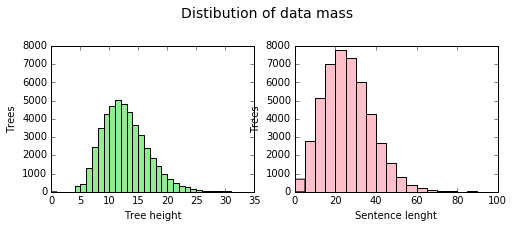

In [21]:
print('Mean tree height', round(scipy.mean([t.height() for t in ptb.trees()]), 2), ', σ', round(scipy.std([t.height() for t in ptb.trees()]), 2))
print('Mean sentence length', round(scipy.mean([len(t.leaves()) for t in ptb.trees()]), 2), ', σ', round(scipy.std([len(t.leaves()) for t in ptb.trees()]), 2))

ptbhistfig = plt.figure(figsize=(8, 3))
ptbhistfig.subplots_adjust(top = 0.8)
ptbhistfig.suptitle('Distibution of data mass', size = 14)
subplot = plt.subplot(121)
subplot.set_xlabel('Tree height')
subplot.set_ylabel('Trees')
subplot.set_ylim(0, 8000)
subplot.hist([t.height() for t in ptb.trees()], bins = range(0, 35), color = 'lightgreen')
subplot = plt.subplot(122)
subplot.set_xlabel('Sentence lenght')
subplot.set_ylabel('Trees')
subplot.set_ylim(0, 8000)
subplot.hist([len(t.leaves()) for t in ptb.trees()], bins = range(0, 100, 5), color = 'pink')
ptbhistfig.show(warn = False)

Next, let's briefly look at how these two features of the data interact. We calculate the covariance matrix, and do a scatterplot.

[[  15.68295191   34.43193708]
 [  34.43193708  147.71454996]]


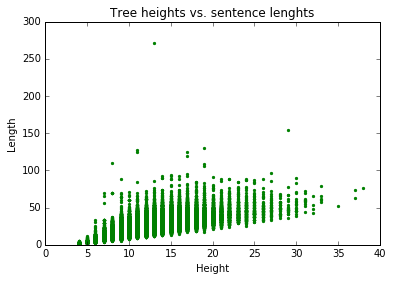

In [15]:
print(scipy.cov([t.height() for t in ptb.trees()], [len(t.leaves()) for t in ptb.trees()]))
plt.title('Tree heights vs. sentence lenghts')
plt.xlabel('Height')
plt.ylabel('Length')
plt.xlim(0, 40)
plt.ylim(0, 300)
plt.scatter([t.height() for t in ptb.trees()], [len(t.leaves()) for t in ptb.trees()], marker = '.', color = 'green')

Let's look at that long, relatively shallow outlier.

In [502]:
print(max(ptb.trees(), key = lambda l: len(l.leaves())))

(TOP
  (S
    (NP-SBJ-3 (NP (DT The) (NN following)) (FRAG (-NONE- *ICH*-4)))
    (VP
      (VP
        (VBD were)
        (VP
          (VP (VBN barred) (NP (-NONE- *-3)))
          (CC or)
          (VP
            (PRN
              (, ,)
              (SBAR-LOC
                (WHADVP-2 (WRB where))
                (S
                  (NP-SBJ-1 (-NONE- *))
                  (VP
                    (VBN noted)
                    (NP (-NONE- *-1))
                    (ADVP-LOC (-NONE- *T*-2)))))
              (, ,))
            (VBN suspended)
            (NP (-NONE- *-3)))))
      (CC and)
      (VP
        (VBD consented)
        (PP-CLR (TO to) (NP (NNS findings)))
        (PP
          (IN without)
          (S-NOM
            (NP-SBJ (-NONE- *-3))
            (VP
              (VBG admitting)
              (CC or)
              (VBG denying)
              (NP (NN wrongdoing)))))))
    (: :)
    (FRAG-4
      (FRAG
        (NP-SBJ
          (NP (NNP Edward) (NNP L.) (NNP Cole))

What a silly tree, looks like some sort of a table. Oh well.

## Data splitting

In machine learning tasks, we want to split the data to training, testing, and in this case also into development sets. In Machine Learning in general, many strategies for data splitting exist. Charniak (2000), as well as Ringger et al., (2004) claim that the following split of the Wall Street Journal (WSJ) sections of Penn Treebank is the accepted standard in the parsing community:

* 2-21 training set
* 23 test set
* 24 development test

Let's apply this conventional splitting to the data we have loaded.

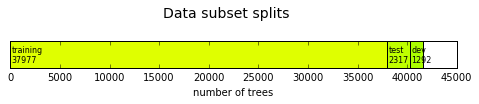

In [8]:
pennsplits = {'training': ['02.trees', '03.trees', '04.trees',
                           '05.trees', '06.trees', '07.trees',
                           '08.trees', '09.trees', '10.trees',
                           '11.trees', '12.trees', '13.trees',
                           '14.trees', '15.trees', '16.trees',
                           '17.trees', '18.trees', '19.trees',
                           '20.trees', '21.trees'],
              'test': ['23.trees'],
              'dev': ['24.trees']}
ptb.setsplits(pennsplits)
ptb.plotsplits()

The training set is only used to extract the languages model. The test set is placed aside until development work is done, and remains untouched until the experiments are conducted. All development work, including possible parameter tuning etc. is done on the dev set, to keep the test set pristine. The development set "stands in" for the test set, and by being small enough, also helps to keep the computational complexity down during design and development.

Developing using the test set will easily lead to over-fitting, and to results that do not generalize. Therefore it is always kept aside and only used for the experiments. The dev set is excluded from the experiments.

The dev set could also be constructed by sampling from the training and tests sets.

## Training

Next, extract the grammar and the lexicon from the training set. These two serve as a representation, a model of the language. A *probabilistic context-tree grammar* (PCFG) is defined as 5-tuple $G = N, T, R, S, P$, where $N$ is the set of non-terminal symbols, $T$ the set of terminal symbols, ie. the lexicon, $R$ the set of production rules, $S \in N$ the start symbol, and $P$ the probabilities of the production rules.

With the `BinPar` parser, the production rules $R$ are separated into two subsets, the grammar rules $P_g$ and the lexical rules $P_l$. The first of these yield non-terminals, the latter terminals. Formally, $P_g = \{ A \rightarrow B \mid A \in N \textrm{ and } B = r_1, r_2 \ldots r_n \textrm{ where } r_1 \ldots r_n \in N\}$, and $P_l = \{ A \rightarrow s \mid A \in N \textrm{ and } s \in T\}$.

The `BinPar` parser itself calculates the production probabilities $P$ from counts in the grammar and lexical files.

In [10]:
lm = LanguageModel(ptb)
%time lm.train()

Let's look at some arbitrary grammar rules from the file and check that they look correct, and check how many of them were extracted and written. Also, a few top training rules are listed, with their frequencies.

In [49]:
with open(lm.grammarfile) as fd:
    [print(line.strip()) for line in fd.readlines()[50:55]]
    fd.seek(0)
    print('Number of training grammar rules written', len(fd.readlines()))

# Functional style is far from computationally efficient, when used like this
#[(rule, ptb.grammar('training').grammar[rule]) for rule in sorted(ptb.grammar('training').grammar, key = ptb.grammar('training').grammar.get, reverse = True)[0:10]]
g = ptb.grammar('training').grammar
[(rule, g[rule]) for rule in sorted(g, key = g.get, reverse = True)[0:10]]

1 VP VBG NP NP-TMP , PP-TMP
15 PP-TMP-PRD IN NP
1 VP VBN NP PP-CLR PP PP-MNR
1 S NP-SBJ-16 VP .
1 VP VBN NP ADVP-MNR ADVP-LOC-TMP
Number of training grammar rules written 30653


[(PP -> IN NP, 39023),
 (TOP -> S, 33710),
 (S -> NP-SBJ VP, 32650),
 (NP-SBJ -> -NONE-, 21734),
 (NP -> NP PP, 20966),
 (NP -> DT NN, 19841),
 (S -> NP-SBJ VP ., 13351),
 (VP -> TO VP, 12448),
 (PP-LOC -> IN NP, 11357),
 (NP-SBJ -> PRP, 11022)]

Let's check some arbitrary lexical rules too, and see how many got extracted and written into the file. According to *Zipf's Law*, the logarithmic ranking of the words in the lexicon should be linearly inversily proportional to their logarithmic frequency; after the few most common classes the frequency drops rapidly, and a long tail of hapaxes lingers on. This is a well-known property of natural languages.

Messrs.	NNPS 10
12,345	CD 1
nationalization	NN 2
scarlet	JJ 1
Butter-Nut	NNP 1
Number of lexical rules written 51192


/usr/lib/python3/dist-packages/numpy/lib/scimath.py:262: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)


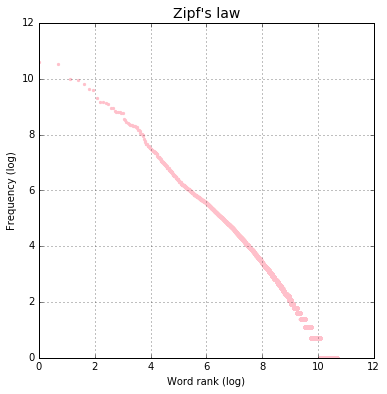

In [29]:
with open(lm.lexiconfile) as fd:
    [print(line.strip()) for line in fd.readlines()[50:55]]
    fd.seek(0)
    print('Number of lexical rules written', len(fd.readlines()))

with open(lm.lexiconfile) as fd:
    lrules = {}
    for line in fd.readlines():
        word, pos, count = line.split()
        count = int(count)
        if word not in lrules:
            lrules[word] = 0
        lrules[word] += count
    plt.figure(figsize=(6,6))
    plt.title('Zipf\'s law', size = 14)
    plt.xlabel('Word rank (log)')
    plt.ylabel('Frequency (log)')
    plt.xlim(0, 12)
    plt.ylim(0, 12)
    plt.grid(True)
    plt.scatter(scipy.log(range(0, len(lrules))), scipy.log([lrules[r] for r in sorted(lrules, key = lrules.get, reverse = True)]), marker = '.', color = 'pink')

Sentences of the development set are extracted into a file. This file will then be parsed using the grammar and lexicon acquired from the training set.

In [8]:
ptb.write_sentences('sentences-dev', 'dev')

## About PCFG

A probabilistic context free grammar parser is a program, which constructs a parse structure, given a grammar $G$, and an input sentence $s$. Using the definition of PCFG above, $s$ is a list of words $s = w_1, w_2, \ldots w_n$ such that each $w \in T$, ie. each word of the sentence is in the lexicon of the language, and $S \Rightarrow s$, $s$ is derivable from the start symbol $S$.

Generally speaking, context-free grammars are a way to describe languages. CFGs describe the context-free languages, a superset of the regular languages. The class of theoretical computing machines known as the *push-down automata* (PDA) recognize the context-free languages (Sipser, 2013). PDA are like regular automata, but with have a simple, but infite memory device: the stack. Several kinds of machines exist, most importantly recognizers, parsers and transducers. Of these, deterministic PDA machines, and the related deterministic context-free languages and grammars can produce one, or possibly many parses for each input, based on $G$. These have been influential for the NLP domain, and have nice theoretical properties. Disambiguation strategies between multiple parses depend on what is suitable for a given task. Probabilistic CFG (PCFG) are an extension of CFGs, and each rule has a probability in $P$. These can be used for disambiguation between multiple parses.

CFGs describe relationships between terms in the language. In the domain of natural language processing the terms are typically the part-of-speech tags and the words of the language in question. Depending on how one looks at it, the grammar rules themselves have have a strong independence assumption in straight-forward CFGs.

Several algorithms for CFG parsing exist, CKY and Earley being the classics (Jurafsky and Martin, 1999). For the purposes of this paper, the Cocke, Kasami, Younger (CKY, aka CYK) is the most interesting, since the `BinPar` is an implementation of it. CKY is a dynamic programming algorithm, which means that as it parses the input sentence bottom-up, left-to-right, it builds a chart of gradually longer and longer constituents it has already constructed. This makes CKY efficient in terms of computing complexity, and it performs the complex task of parsing in $O(n^3)$. Upon completion, a tree or a number of trees are retrieved from the chart, and returned.

`BinPar`, in depth described in Schmid (2004), uses a bit martix to store the parses, making it suitable for sparse data and highly ambiguous grammar. `BinPar` can implements the Viterbi algorithm and can optionally use that to retrieve the single, most probable parse solution from the chart. This method is used in this paper.

An object reprentation of the `BinPar` parser is defined.

In [55]:
class BinPar:
    """A little wrapper class around BinPar."""
    def __init__(self, binpath):
        """
        @param binpath: str to binary path
        @param args: str of arguments"""
        assert os.path.exists(binpath)
        self.binpath = binpath
        
    def parse(self, languagemodel, sentencesfile, outfile, args = None):
        """Run BinPar. Returns a filename."""
        assert os.path.exists(languagemodel.grammarfile)
        assert os.path.exists(languagemodel.lexiconfile)
        assert os.path.exists(sentencesfile)
        
        cmdline = " ".join([
            self.binpath,
            args,
            languagemodel.grammarfile,
            languagemodel.lexiconfile,
            sentencesfile,
            outfile])
        print(cmdline)
        exitcode = os.system(cmdline)
        if exitcode != 0:
            # should throw an exception
            print(self.binpath, 'exited with code', exitcode)
            return None
        else:
            return self.postprocess(outfile, outfile + "_pp")
        
    def postprocess(self, bitparparsesfile, postprocessedparsesfile):
        """Postprocess BinPar parses."""
        assert os.path.exists(bitparparsesfile)
        
        with open(bitparparsesfile, 'r') as infd:
            with open(postprocessedparsesfile, 'w') as outfd:
                for line in infd:
                    if line.startswith("No parse for"):
                        line = '(TOP nil)\n'
                    else:
                        line = re.sub(r'\\', '', line)
                        line = re.sub(r'/', '\/', line)
                    outfd.write(line)
        return postprocessedparsesfile

An object representation of the EVALB software, which calculates PARSEVAL metrics.

In [12]:
class Evalb:
    """A little wrapper class around EVALB."""
    def __init__(self, binpath):
        self.binpath = binpath

    def evaluate(self, treebank, split, parseroutputfile, args = ''):
        assert os.path.exists(parseroutputfile)
        assert split in treebank.splits.keys()
        
        goldtrees = 'goldtrees'
        with open(goldtrees, 'w') as fd:
            for tree in treebank.trees(split):
                fd.write(str(tree))

        cmdline = " ".join([
                self.binpath,
                args,
                treebank.splits[split][0],
                parseroutputfile,
                ">" + 'eval'
            ])
        print(cmdline)
        exitcode = os.system(cmdline)
        if exitcode != 0:
            print('evalb exited with', exitcode)
        
    def parseresults(self, evalbfile):
        """Return EVALB results, and summary as a Pandas structures."""
        assert os.path.exists(evalbfile)
        
        columns = ['id', 'len', 'stat', 'recall', 'precision', 'matchedbracket', 'bracket_gold', 'bracket_test', 'cross_bracket', 'cross_words', 'correcttags', 'tagaccuracy']
        evaltrees = pd.DataFrame(dtype = 'float64', columns = columns)
        
        with open(evalbfile) as fd:
            line = fd.readline()
            # skip over headers
            while not line.startswith('===='):
                line = fd.readline()
            line = fd.readline()
            # get the individual tree results
            while not line.startswith('===='):
                s = pd.Series(pd.to_numeric(line.split()), index = columns)
                evaltrees = evaltrees.append(s, ignore_index = True)
                line = fd.readline()
            while not line.startswith('-- All'):
                line = fd.readline()
            line = fd.readline()

            # get the summary
            summaryvalues = []
            while not line.isspace():
                summaryvalues.append(line.split('=')[1].strip())
                line = fd.readline()
            #evalsummary = pd.Series(pd.to_numeric(summaryvalues), index = ['no_sent', 'no_errsent', 'no_skipsent', 'no_validsent', 'bracrecall', 'bracprecision', 'bracfmeas', 'completematch', 'avgcrossing', 'no_crossing', 'twoorlesscrossing', 'taggingaccuracy'])
            evalsummary = {'no_sent': int(summaryvalues[0]),
                           'no_errsent': int(summaryvalues[1]),
                           'no_skipsent': int(summaryvalues[2]),
                           'no_validsent': int(summaryvalues[3]),
                           'bracrecall': float(summaryvalues[4]),
                           'bracprecision': float(summaryvalues[5]),
                           'bracfmeas': float(summaryvalues[6]),
                           'completematch': float(summaryvalues[7]),
                           'avgcrossing': float(summaryvalues[8]),
                           'no_crossing': float(summaryvalues[9]),
                           'twoorlesscrossing': float(summaryvalues[10]),
                           'taggingaccuracy': float(summaryvalues[11])}

        return evaltrees, evalsummary

## About evaluation

To evaluate performance, metrics are useful. When a correct, or at least shared idea of correctness is available, experimental results can be compared to them. Correct matches are one obvious way to compare, but some sort of a distance can serve as an performance function. In the domain of parsing in computational linguistics, resources such as Penn Treebank provide gold standard trees for comparing results.

In this paper the PARSEVAL metrics are used (Black et al, 1991: Manning and Schütze, 1999 pp. 432-437). The PARSEVAL metrics resulted in a 1991 workshop, and have gained standard status thoughtout the 1990s in the research community, although not without critique (e.g. Romanyshyn and Dyomkin, 2014; Manning and Schütze, 1999 especially regarding Penn Treebank) and further developments.

PARSEVAL metrics are similarity based, and evaluate gold and candidate parse trees pairwise. The unit of analysis are constituents, ie. labeled subtrees of the parse structure which annotate spans of words in the sentence. From these, *precision*, *recall*, their weighted aggregate *F-measure*, and *cross-bracketing* are calculated. The first three are familiar from information retrieval and other tasks and the *F1* special case of the F-measure, ie. the harmonic mean is used. The metrics measure ratios of true positives in the result set, and true positives of all the positives in the data. In parsing, they capture agreements of the bracket spans between the gold and candidate parses. For instance this `PP` attachment error error.

    (S (NP (A a)) (VP(B b)   (PP (C c))) ) gold
    (S (NP (A a)) (VP(B b) ) (PP (C c)))   candidate

The constituents in the gold parse are `S(0, 3)`, `NP(0, 1)`, `VP(1, 3)` and `PP(2, 3)`, and in the candidate parse `S(0, 3)`, `NP(0, 1)`, `VP(1, 2)` and `PP(2, 3)`. In this example precision is $3/4$ and recall $3/4$. (Farrar, 2010)

The fourth PARSEVAL metric mentioned above, cross-bracketing is specific to parsing tasks, and captures errors such as this one (*ibid.*, adapted):

    (  (     (        )  )  ) gold
    (  (  (        )     )  ) candidate
     w1 w2 w3 w4 w5 w6 w7 w8

In addition to the span of brackets, one can also look at the correctness of the bracket labels.

In this paper, the `EVALB` software is used to calculate the PARSEVAL metrics. It should be noted that the data manipulations and normalizations explained in Black et al (1991) are not performed in this work.

In [13]:
class Experiment:
    """A high-level abstraction of an PCFG experiment."""
    def __init__(self, exid, treebank, languagemodel, split, sentencesfile, parser, evaluator, parserargs = None):
        self.exid = exid
        self.treebank = treebank
        self.languagemodel = languagemodel
        self.split = split
        self.sentencesfile = sentencesfile
        self.parser = parser
        self.evaluator = evaluator
        self.parserargs = parserargs
    
    def conduct(self, dry = True):
        assert os.path.exists(self.languagemodel.grammarfile)
        assert os.path.exists(self.languagemodel.lexiconfile)
        
        # print(self.parser.binpath, self.parserargs, self.languagemodel, self.sentencesfile, 'bpout-' + self.split + '-' + self.exid)
        
        if not dry:
            self.parsesfile = self.parser.parse(self.languagemodel, self.sentencesfile, 'bpout-' + self.split + '-' + self.exid, args = self.parserargs)
        else:
            self.parsesfile = 'bpout-' + self.split + '-' + self.exid + '_pp'
            print('⚠ This is a dry run with cached parses from', self.parsesfile)
        self.candidates = [nltk.ParentedTree.fromstring(line) for line in open(self.parsesfile).readlines()]
        self.gold = self.treebank.trees(self.split)
        self.evaluator.evaluate(self.treebank, self.split, self.parsesfile)
        self.results, self.summary = self.evaluator.parseresults('eval')
        print('Experiment done')
        return self.results, self.summary
    
    def print_parseeval(self):
        print('Summary precision:', self.summary['bracprecision'])
        print('Summary recall:', self.summary['bracrecall'])
        print('Summary bracketing F1:', self.summary['bracfmeas'])
        
    def print_meanprecrecall(self):
        assert type(self.results) is pd.DataFrame
        
        print('Mean precision:', round(self.results.precision.mean(), 2), ', σ', round(self.results.precision.std(), 2))
        print('Mean recall:', round(self.results.recall.mean(), 2), ', σ', round(self.results.recall.std(), 2))
        
    def plot_precrecall(self):
        assert type(self.results) is pd.DataFrame
        
        plt.figure(figsize = (13, 4))
        plt.subplots_adjust(top = 0.8)
        plt.suptitle('Masses of precision and recall (' + self.exid + ', ' + self.split + ')', size = 14)

        plt.subplot(131)
        plt.title('Mass of precision')
        plt.xlabel('Bracket precision')
        plt.ylabel('Trees')
        plt.ylim(0, 500)
        plt.hist(self.results.precision, color = 'lightblue')

        plt.subplot(132)
        plt.title('Mass of recall')
        plt.xlabel('Bracket recall')
        plt.ylabel('Trees')
        plt.ylim(0, 500)
        plt.hist(self.results.recall, color = 'green')

        plt.subplot(133)
        plt.title('Precision vs recall')

        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.grid(True)
        plt.scatter(self.results.precision, self.results.recall, marker = '.')
        
    def plot_lencrossbracket(self):
        assert type(self.results) is pd.DataFrame
        
        plt.axis([0, self.results.len.max(), 0, self.results.cross_bracket.max()])
        plt.title('Sentence length vs. crossed brackets')
        plt.xlabel('Length')
        plt.ylabel('Crossed brackets')
        plt.grid(True)
        plt.scatter(self.results.len, self.results.cross_bracket, marker='.')

### Exploration and development

To get an idea of the shape of the data, the parser performance, and some of the errors, let's explore without any transformation of the training data. Parsing is conducted on the development dataset.

In [14]:
binpar = BinPar('./BitPar/src/bitpar')
evalb = Evalb("./EVALB/evalb")
devexperiment1 = Experiment('dev1', ptb, lm, 'dev', 'sentences-dev', binpar, evalb, parserargs = '-v -s TOP')

%time dev1results, dev1summary = devexperiment1.conduct(dry = True)

./BitPar/src/bitpar -v -s TOP <__main__.LanguageModel object at 0x7fdff0eab400> sentences-dev bpout-dev-dev1
⚠ This is a dry run with cached parses from bpout-dev-dev1_pp
./EVALB/evalb  24.trees bpout-dev-dev1_pp >eval
Experiment done
CPU times: user 6.61 s, sys: 136 ms, total: 6.74 s
Wall time: 7.09 s


Let's look at the summaries of the key PARSEVAL measures.

In [162]:
devexperiment1.print_parseeval()

Summary precision: 71.73
Summary recall: 68.84
Summary bracketing F1: 70.25


And how precision and recall are distributed.

Mean precision: 74.58 , σ 17.06
Mean recall: 71.93 , σ 17.2


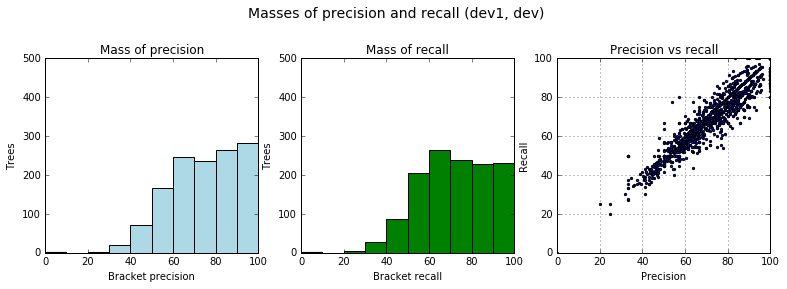

In [163]:
devexperiment1.print_meanprecrecall()
devexperiment1.plot_precrecall()

Let's look at the profile of the crossed brackets error metric. Lower, ie to the left, is better.

count    1292.000000
mean        3.881579
std         4.254572
min         0.000000
25%         0.000000
50%         3.000000
75%         6.000000
max        26.000000
Name: cross_bracket, dtype: float64

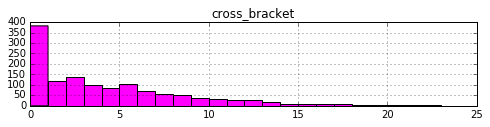

In [44]:
dev1results.hist(column = 'cross_bracket', color = 'magenta', bins = range(0, int(dev1results.cross_bracket.max())), figsize = (8, 1.5))
dev1results.cross_bracket.describe()

Let's explore how length of sentences and number of crossed brackets interact. The crossed brackets is an error metric, something we would like to minimize. Intuitively it seems that it would positively correlate with length of the sentence.

Pearson's correlation coefficient 0.66


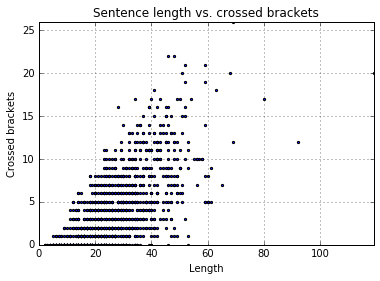

In [164]:
print('Pearson\'s correlation coefficient', round(scipy.stats.pearsonr(dev1results.len, dev1results.cross_bracket)[0], 2))
devexperiment1.plot_lencrossbracket()

A few correct parses, with 100% precision and recall.

In [446]:
for i in list(int(i) for i in dev1results[(dev1results.precision == 100) & (dev1results.recall == 100)].sample(3).id):
    t = devexperiment1.treebank.trees(devexperiment1.split)[i]
    print()
    print("🌲 Tree", i, "(" + devexperiment1.split + "):", " ".join(t.leaves()))
    print(t)


🌲 Tree 968 (dev): `` I look at where deals can get done , '' he says *T*-1 , `` and they 're not getting done '' at current prices .
(TOP
  (S-1
    (`` ``)
    (S
      (NP-SBJ (PRP I))
      (VP
        (VBP look)
        (PP
          (IN at)
          (SBAR
            (WHADVP (WRB where))
            (S
              (NP-SBJ (NNS deals))
              (VP (MD can) (VP (VB get) (VP (VBN done)))))))))
    (PRN
      (, ,)
      ('' '')
      (S (NP-SBJ (PRP he)) (VP (VBZ says) (S (-NONE- *T*-1))))
      (, ,)
      (`` ``))
    (CC and)
    (S
      (NP-SBJ (PRP they))
      (VP
        (VBP 're)
        (RB not)
        (VP
          (VBG getting)
          (VP
            (VBN done)
            ('' '')
            (PP-CLR (IN at) (NP (JJ current) (NNS prices)))))))
    (. .)))

🌲 Tree 280 (dev): 2 . `` Service '' should be service .
(TOP
  (S
    (LST (LS 2) (. .))
    (`` ``)
    (NP-SBJ (NN Service))
    ('' '')
    (VP (MD should) (VP (VB be) (NP-PRD (NN service))))
    (. .))

Many strategies can be utilized to analyze errors. Data-driven possibilities, given gold, include e.g. building a confusion matrix to inspect sees which grammar rules are mistaken for which, and how the parser overlaps different syntactic structures. One can also see which errors happen higher up the tree or closer to the lexicon, what kinds of subtrees are resilient or vulnerable to which kinds of errors, measure graph translations by using for instance generic graph morphing (e.g. edit distance). To bind to the lexicon, one can see how errors are distributed across common or rare words in an attempt to prioritize analysis of errors which have wider consequences for an upstream task in an NLP pipeline.

Here, focus is briefly given to attachment errors. A common parsing error is the *PP attachment error*, when propositional phrases are connected to the wrong place. Hilarity ensues. Let's find some.

In [17]:
def attachment_errors(gold, candidates, tag):
    """Returns a tuple (pos, subtree, goldtree, candidatetree, index) for all attachment errors of tag.
    
    In the return value pos is the (incorrect) position of
    the attachment in the candidate tree, subtree is the
    erroneuosly attached subtree of the candidate, goldtree
    is the gold tree, candidatetree is the candidate tree,
    and index in the set of input trees."""
    assert type(gold) is list
    assert type(candidates) is list
    assert len(gold) == len(candidates)
    assert type(tag) is str

    for i, gt, ct in zip(enumerate(gold), gold, candidates):
        for p in [cta.treeposition() for cta in ct.subtrees() if cta.label() == tag]:
            try:
                if gt[p] == ct[p]:
                    yield None
                else:
                    yield p, ct[p], gt, ct, i[0]
                #yield p, ct[p].parent(), gt, ct
            except TypeError:
                continue
            except ValueError:
                yield p, ct[p], gt, ct, i[0]
                #yield p, ct[p].parent(), gt, ct
            except IndexError:
                yield p, ct[p], gt, ct, i[0]

attacherrors_pp = [error for error in attachment_errors(devexperiment1.gold, devexperiment1.candidates, 'PP')]
print('Number of attachments for this tag: ', len(attacherrors_pp))
print('Correct attachments for this tag:', len([v for v in attacherrors_pp if v == None]))
print()
print(devexperiment1.results.iloc[attacherrors_pp[100][4]])
print()
print('Subtree', attacherrors_pp[100][1], 'incorrectly attached to', attacherrors_pp[100][0])
print()
print('🌲  Gold parse tree')
print(attacherrors_pp[100][2].pprint())
print()
print('🌲  Candidate parse tree')
print(attacherrors_pp[100][3].pprint())

Number of attachments for this tag:  1952
Correct attachments for this tag: 225

id                70.00
len               29.00
stat               0.00
recall            66.67
precision         72.73
matchedbracket    16.00
bracket_gold      24.00
bracket_test      22.00
cross_bracket      4.00
cross_words       29.00
correcttags       26.00
tagaccuracy       89.66
Name: 69, dtype: float64

Subtree (PP (IN at) (NP (DT the) (NN firm))) incorrectly attached to (0, 1, 2, 1, 1, 2, 1, 1)

🌲  Gold parse tree
(TOP
  (S
    (NP-SBJ (DT The) (JJ first) (NN episode))
    (VP
      (VBD concluded)
      (PP-CLR
        (IN with)
        (NP
          (NP (DT a) (ADJP (RB marvelously) (JJ cute)) (NN scene))
          (SBAR
            (WHPP-2 (IN in) (WHNP (WDT which)))
            (S
              (NP-SBJ (DT the) (NN trading-room) (NN crew))
              (VP
                (VBD minded)
                (NP
                  (NP (DT a) (NN baby))
                  (, ,)
                  (NP
  

In the above parse the problem is caused by erroneuous tagging of the propositional phrase; the parser assings the tag `PP` to the phrase *at the firm* near the end of the sentence, thought the gold parse has the more specific tag `PP-LOC`. There are also issues higher up the tree, so errors are cascading down from `PP-CLR` node, which the parser attached high, to the `VP`.

Let's focus at the cascading problem.

In [494]:
print('Subtree', attacherrors_pp[150][1], 'incorrectly attached to', attacherrors_pp[150][0])
print()
print(devexperiment1.results.iloc[attacherrors_pp[150][4]])
print()
print('🌲  Gold parse tree')
print(attacherrors_pp[150][2].pprint())
print()
print('🌲  Candidate parse tree')
print(attacherrors_pp[150][3].pprint())

Subtree (PP (IN of) (NP (NNP October))) incorrectly attached to (0, 1, 2, 1, 1)

id                98.00
len               28.00
stat               0.00
recall            68.42
precision         76.47
matchedbracket    13.00
bracket_gold      19.00
bracket_test      17.00
cross_bracket      2.00
cross_words       28.00
correcttags       26.00
tagaccuracy       92.86
Name: 97, dtype: float64

🌲  Gold parse tree
(TOP
  (S
    (NP-SBJ
      (DT The)
      (CD eight)
      (JJ major)
      (JJ domestic)
      (NN auto)
      (NNS makers))
    (VP
      (VP
        (VBD sold)
        (NP
          (NP
            (CD 160,510)
            (ADJP (NNP North) (JJ American-made))
            (NNS cars)))
        (PP-TMP
          (IN in)
          (NP
            (NP (DT the) (JJ first) (CD 10) (NNS days))
            (PP (IN of) (NP (NNP October)))))
        (, ,))
      (NP
        (NP (DT a) (ADJP (CD 12.6) (NN %)) (NN drop))
        (PP (IN from) (ADVP (NP (DT a) (NN year)) (RBR earlier)))))

Here, the propositional phrase *of October* is attached incorrectly, because higher up the tree, in the phrase *The eight major domestic auto makers* a different subparse is produced, thereby misaligning all the further indexes of the tree. This cascading of errors is a recognized problem with the PARSEVAL metrics (Romanyshyn and Vsevolod, 2014).

Let's look at other attachment errors. Coordination attachment errors, ie. misplacing of *and*, *or*, *but* etc. can significantly alter the meaning of the sentences. In the development corpus, the following ratio of coordination attachments are correct.

([<matplotlib.patches.Wedge at 0x7f12869d8860>,
  <matplotlib.text.Text at 0x7f12869f4d30>])

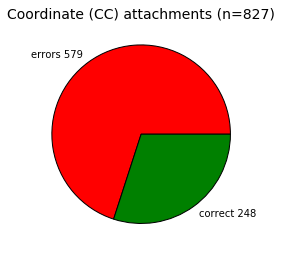

In [444]:
attacherrors_cc = [error for error in attachment_errors(devexperiment1.gold, devexperiment1.candidates, 'CC')]
plt.axes(aspect = 1)
plt.title('Coordinate (CC) attachments (n=' + str(len(attacherrors_cc)) + ')', size = 14)
plt.pie([len([a for a in attacherrors_cc if a != None]), len([a for a in attacherrors_cc if a == None])], labels = ['errors ' + str(len([a for a in attacherrors_cc if a != None])), 'correct ' + str(len([a for a in attacherrors_cc if a == None]))], colors = ['red', 'green'])

The function `attachment_errors` above is generic enough to quite trivially quantify and visualize distribution of the attachment errors in the data in question. This would guide further analysis and development work.

It should be noted that the above exploration of attachment errors is based on global positions of the subtree labels (e.g. `PP` and `CC`), and errors are measured from the root of the three to the attached subtree in question. This is quite a harsh way to define errors, and suffers from cascading.

Another, more forgiving measure of attachments errors would traverse upwards from the attaching node, or alternatively exploring sideways to siblings and other local context. This would perhaps be even too forgiving, and would focus around the particular occurrences of errors, and not at the parse tree, which is what we want to try to get right. The `nltk.ParentedTree` class would make such a traversing setup quite easy to implement, but it is not done in this paper.

### Development: Plugging the grammar

Two transformations are suggested to the grammar: *local transformation* and *lexicalization*. Local transformations annotate nodes with a head-child, which is a selected child node. Various sets of rules for selecting has been proposed, perhaps most famously in Collins (1999; also 2003, see also Chiang and Bikel 2002). Transformations such as these are linguistically motivated, and combine data-driven learning and analytical rules.

The following rules for selecting the head-child are from Collins (1999).

In [18]:
headchildrules = {'ADJP': ('l', ['NNS', 'QP', 'NN', '$', 'ADVP', 'JJ', 'VBN', 'VBC', 'ADJP', 'JJR', 'NP', 'JJS', 'DT', 'FW', 'RBB', 'SBAR', 'RB']),
                  'ADVP': ('r', ['RB', 'RBR', 'RBS', 'FW', 'ADVP', 'TO', 'CD', 'JJR', 'JJ', 'IN','NP', 'JJS', 'NN']),
                  'CONJP': ('r', ['CC', 'RB', 'IN']),
                  'FRAG': ('r', []),
                  'INTJ': ('l', []),
                  'LST': ('r', ['LS', ':']),
                  'NAC': ('l', ['NN', 'NNS', 'NNP', 'NNPS', 'NP', 'NAC', 'EX', '$', 'CD', 'QP', 'PRP', 'VBG', 'JJ', 'JJS', 'JJR', 'ADJP', 'FW']),
                  'PP': ('r', ['IN', 'TO', 'VBG', 'VBN', 'RP', 'FW']),
                  'PRN': ('l', []),
                  'PRT': ('r', ['RP']),
                  'QP': ('l', ['$', 'IN', 'NNS', 'NN', 'JJ', 'RB', 'DT', 'CD', 'NCD', 'QP', 'JJR', 'JJS']),
                  'RRC': ('r', ['VP', 'NP', 'ADVP', 'ADJP', 'PP']),
                  'S': ('l', ['TO', 'IN', 'VP', 'S', 'SBAR', 'ADJP', 'UCP', 'NP']),
                  'SBAR': ('l', ['WHNP', 'WHPP', 'WHADVP', 'WHADJP', 'IN', 'DT', 'S', 'SQ', 'SINV', 'SBAR', 'FRAG']),
                  'SBARQ': ('l', ['SQ', 'S', 'SINV', 'SBARQ', 'FRAG']),
                  'SINV': ('l', ['VBZ', 'VBD', 'VBP', 'VB', 'MD', 'VP', 'S', 'SINV', 'ADJP', 'NP']),
                  'SQ': ('l', ['VBZ', 'VBD', 'VBP', 'VB', 'MD', 'VP', 'SQ']),
                  'UCP': ('r', []),
                  'VP': ('l', ['TO', 'VBD', 'VBN', 'MD', 'VBZ', 'VB', 'VBG', 'VBP', 'VP', 'ADJP', 'NN', 'NNS', 'NP']),
                  'WHADJP': ('l', ['CC', 'WRB', 'JJ', 'ADJP']),
                  'WHADVP': ('r', ['CC', 'WRB']),
                  'WHNP': ('l', ['WDT', 'WP', 'WP$', 'WHADJP', 'WHPP', 'WHNP']),
                  'WHPP': ('r', ['IN', 'TO', 'FW'])
                 }

In [19]:
def transformlocal(tree, localtransformations):
    """Does local transformation of a tree. Note: in-place."""
    # newtree = tree.copy(deep = True)
    # for child in [s for s in newtree.subtrees()]:
    for child in [s for s in tree.subtrees()]:
        try:
            d, trans = localtransformations[child.label()]
            if d == 'l':
                compare = min
            else:
                compare = max
            child.set_label("_".join((child.label(), compare(child, key = lambda l: trans.index(l.label())).label())))
        except KeyError:
            continue
        except ValueError:
            continue
    #return newtree

A new treebank is defined and loaded for the grammar transformations.

In [20]:
del(ptb_loctrans)
%time ptb_loctrans = Treebank(treedatafile)
ptb_loctrans.setsplits(pennsplits)

for tree in ptb_loctrans.trees('training'):
    transformlocal(tree, headchildrules)

print('Number of trees with transformations in training', sum([ot != tt for ot, tt in zip(ptb_loctrans.trees('training'), ptb.trees('training'))]), 'out of', len(ptb_loctrans.trees('training')))

CPU times: user 41.8 s, sys: 1.33 s, total: 43.1 s
Wall time: 47.9 s
Number of trees with transformations in training 31887 out of 37977


In [21]:
lm_loctrans = LanguageModel(ptb_loctrans, grammarfile = 'grammar-train-localtrans', lexiconfile = 'lexicon-train-localtrans')
%time lm_loctrans.train()

with open(lm_loctrans.grammarfile) as fd:
    print('Number of training grammar rules written', len(fd.readlines()))

CPU times: user 59.4 s, sys: 2.54 s, total: 1min 1s
Wall time: 1min 21s
Number of training grammar rules written 34560


In [22]:
devexperiment2 = Experiment('dev2', ptb_loctrans, lm_loctrans, 'dev', 'sentences-dev', binpar, evalb, parserargs = '-v -s TOP')

%time dev2results, dev2summary = devexperiment2.conduct(dry = True)

./BitPar/src/bitpar -v -s TOP <__main__.LanguageModel object at 0x7fdff0006cc0> sentences-dev bpout-dev-dev2
⚠ This is a dry run with cached parses from bpout-dev-dev2_pp
./EVALB/evalb  24.trees bpout-dev-dev2_pp >eval
Experiment done
CPU times: user 11.7 s, sys: 9.98 s, total: 21.7 s
Wall time: 1min 5s


Let's take a look at the results. A quick cleaning of the tags of the local transformations from the the parser output is necessary, for evaluation.

In [23]:
!sed 's/_[A-Z]*//g' bpout-dev-dev2_pp >bpout-dev-dev2_pp-clean

After the cleaning, the results are reloaded for evaluation. I apologize for the unelegance of this manipulation.

In [38]:
devexperiment2.evaluator.evaluate(devexperiment2.treebank, devexperiment2.split, 'bpout-dev-dev2_pp-clean')
devexperiment2.results, devexperiment2.summary = devexperiment2.evaluator.parseresults('eval')

./EVALB/evalb  24.trees bpout-dev-dev2_pp-clean >eval


Let's inspect the PARSEVAL metrics for this experiment.

In [46]:
devexperiment2.print_parseeval()

Summary precision: 72.47
Summary recall: 70.52
Summary bracketing F1: 71.48


Mean precision: 75.32 , σ 16.97
Mean recall: 73.58 , σ 17.27


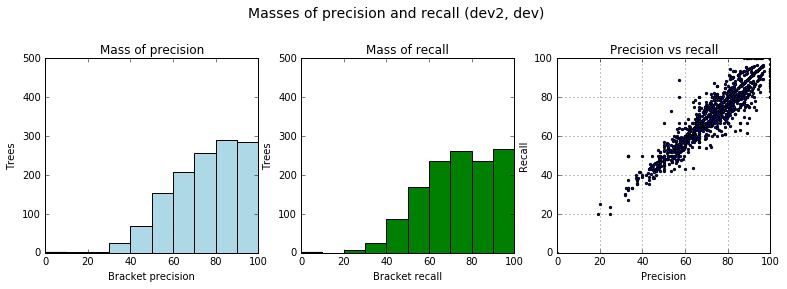

In [47]:
devexperiment2.print_meanprecrecall()
devexperiment2.plot_precrecall()

count    1292.000000
mean        3.730650
std         4.308249
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max        31.000000
Name: cross_bracket, dtype: float64

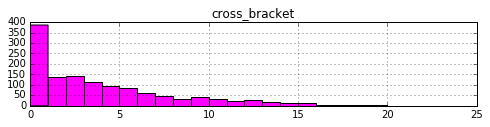

In [43]:
devexperiment2.results.hist(column = 'cross_bracket', color = 'magenta', bins = range(0, int(dev1results.cross_bracket.max())), figsize = (8, 1.5))
devexperiment2.results.cross_bracket.describe()

Are these changes statistically significant, or due to mere chance? Assuming both variables are normally distributed (assumptions which should be checked), and have similar variance, we can compare the two sets of samples.

Testing for the 0.95 confidence level, we calculate the $p$ -value. The null hypothesis is that the distributions are not different from one another.

In [137]:
for metric in ['precision', 'recall', 'cross_bracket']:
    s, p = scipy.stats.ttest_ind(devexperiment1.results[metric], devexperiment2.results[metric])
    print(metric.title(), round(s, 3), ', p', round(p, 3), '*' if p < 0.05 else '')

Precision -1.107 , p 0.269 
Recall -2.43 , p 0.015 *
Cross_Bracket 0.896 , p 0.37 


Of these, recall is statistically significant, in favour of the second variable, ie. the experimental condition. Therefore we can conclude, that the local transformations as implemented here increase the recall of the correct parses. The experimental condition did not improve precision, or the crossing bracket error metric.

## Experiments

Now, let's take out the test data, and run the experiments.

In [ ]:
ptb.write_sentences('sentences-test', 'test')

### Experiment 1: Baseline

The baseline experiment, without experimental condition

In [ ]:
experiment1 = Experiment('ex1', ptb, lm, 'test', 'sentences-test', binpar, evalb, parserargs = '-v -s TOP')

%time ex1results, ex1summary = experiment1.conduct(dry = False)

In [ ]:
experiment1.print_parseeval()

In [ ]:
experiment1.print_meanprecrecall()
experiment1.plot_precrecall()

In [ ]:
experiment1.results.hist(column = 'cross_bracket', color = 'magenta', bins = range(0, int(dev1results.cross_bracket.max())), figsize = (8, 1.5))
experiment1.results.cross_bracket.describe()

### Experiment 2: Local transformations

The first experimental condition, with local transformations.

In [ ]:
experiment2 = Experiment('ex2', ptb_loctrans, lm_loctrans, 'test', 'sentences-test', binpar, evalb, parserargs = '-v -s TOP')

%time ex2results, ex2summary = experiment2.conduct(dry = True)

In [ ]:
experiment2.print_parseeval()

In [ ]:
experiment2.print_meanprecrecall()
experiment2.plot_precrecall()

In [ ]:
experiment2.results.hist(column = 'cross_bracket', color = 'magenta', bins = range(0, int(dev1results.cross_bracket.max())), figsize = (8, 1.5))
experiment2.results.cross_bracket.describe()

### Experiment 3: Lexicalization

The second experimental condition, with lexicalization.

In [ ]:
experiment3 = Experiment('ex3', ptb, lm_lex, 'test', 'sentences-test', binpar, evalb, parserargs = '-v -s TOP')

%time ex3results, ex3summary = experiment3.conduct(dry = True)

In [ ]:
experiment3.print_parseeval()

In [ ]:
experiment3.print_meanprecrecall()
experiment3.plot_precrecall()

In [ ]:
experiment3.results.hist(column = 'cross_bracket', color = 'magenta', bins = range(0, int(dev1results.cross_bracket.max())), figsize = (8, 1.5))
experiment3.results.cross_bracket.describe()

## Conclusions and reflections

Due to the lack of RAM memory (2GB), the three experiments were not run. Their skeletons are provided above, as well as development experiments for the baseline unmodified data, and the experimental condition of the local transformations. The above code is presented to follow the analytical and engineering thinking of the author. With the constructed scaffolding, running the experiments should be a matter of applying CPU time, and retrieving the results.

Based on the development experiment 2 `devexperiment2` on the development training set with local transformations, the transformation achieves sligthly better results than the baseline `devexperiment1`. Whether they are statistically significant, and how, was studied only briefly. The few percents of increase are however achieved on the same data (the development test set) in this case, and the probabilities of the rules have been learned from the data for the PCFG parser, ie. from actual newswire. Inspecting the plots of recall and precision mass distribution, they seem to have stacked a little tighter to the right, towards better scores.

Further developments could go towards several domains of error classification, visualization of parse trees. This would preferably be linguistically motivated. Here the data is from newswire, and other domains could be interesting. There is reason to be suspicious of the Collins' head-finding rules and their generalizability, though this has been addressed in the literature. From software engineering points of view, further development would benefit the object model constructed here. The design principle has been in developing towards . Also, the object model is poorly documented in code and docstrings should be provided. Memory profiling could help solve the issue of not being able to store several copies of `nltk.ParentedTree` object representations of the whole Penn Treebank in memory, in instances of the class `Treebank`. At some parts of this work functional progamming paradigm has been insisted to avoid cluttering the environment, and in some cases this has significant performance implications. Investing in visualization could help understandability and user experience of this work, as well has help in analysis. Versioning would be a useful idea too, and employing some sort of a more rigorous persistency layer, perhaps a CRUD model.

Working within a Jupyter Notebook has it's own limitations from software development point of view, but has proven to be a very fruitful way to compose analytical reports such as this, and the hope is that this paper, and literal programming in general, helps convey thinking processes from the author(s) to the reader(s).

From pedagogical perspective, this has been a very valuable project. Instead of low-level manipulation and parsing of the bracket storage format, the focus has been towards an object-oriented representation of experimental research (I implemented a basic CKY recognizer earlier). Guided by my interests and goals in my studies, the emphasis here has been on applying computation and modelling, and not so much on linguistics. The given task is also technical and artificial in nature and aims at better PARSEVAL metrics, and is not contextualized in an NLP pipeline, framed in a real or a fictional wider scenario, or motivated by for instance linguistic or cognitive theory. Engaging more with literature would always be a good idea, as well as with other peers (researchers or students). A teamwork would perhaps been a preferable mode of doing this. All-in-all I am quite happy with the project.

## References

* Bird, Steven; Loper, Edward and Klein, Ewan, _Natural Language Processing with Python_. O’Reilly Media Inc. (2009) ([website](http://www.nltk.org))

* Black, Ezra. et al.: _A Procedure for Quantitatively Comparing the Syntactic Coverage of English Grammars_. HLT '91 Proceedings of the workshop on Speech and Natural Language Pages 306-311 (1991)

* Charniak, Eugene: _A Maximum-Entropy-Inspired Parser_. Proceedings of NAACL 2000 (2000)

* Chiang, Davig; Bikel, Daniel: _Recovering latent information in treebanks_. COLING (2002)

* Collings, Michael: _Head-Driven Statistical Models for Natural Language Parsing_. Computational Linguistics, vol 29, number 4. (2003)

* Farrar, Scott: _EVALB, Improving CKY Parsing, Hw3_. Lecture notes from CLMA, University of Washington (2010)

* Jurafsky, Dan; Martin, James: _Speech and Language Processing_. Prentice Hall. (1999)

* Manning, Chris and Schütze, Hinrich: _Foundations of Statistical Natural Language Processing_, MIT Press (1999)

* Ringger, Eric; Moore, Robert; Vanderwende, Lucy; Suzuki, Hisami; Charniak, Eugene: _Using the Penn Treebank to Evaluate Non-Treebank Parsers_. European Language Resources Association (2004)

* Romanyshyn, Mariana; Dyomkin, Vsevolod: _The Dirty Little Secret of Constituency Parser Evaluation_. Grammarly blog (2014). ([online](http://tech.grammarly.com/blog/posts/The-Dirty-Little-Secret-of-Constituency-Parser-Evaluation.html#sthash.fMjTjuh6.dpuf))

* Schmid, Helmut: _Efficient Parsing of Highly Ambiguous Context-Free Grammars with Bit Vectors_, Proceedings of the 20th International Conference on Computational Linguistics (COLING 2004), Geneva, Switzerland. ([pdf](http://www.cis.uni-muenchen.de/~schmid/papers/BitPar.pdf))

* Sipser, Michael: _Introduction to the Theory of Computation_, 3rd international edition. Cengage learning (2013)